In [95]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

# Normalisation

In [96]:
with open('data_raw.csv', 'r', encoding='utf-8') as infile, open('data_clean.csv', 'w', encoding='utf-8') as outfile:
    for ligne in infile:
        if ligne.strip():  
            if ligne.startswith('"'):
                ligne = ligne[1:]
                ligne = ligne.replace('"""', '"')
                ligne = ligne.replace('""', '"')
            outfile.write(ligne)
            

In [97]:
df = pl.read_csv('data_clean.csv', has_header=True, schema_overrides={'date':pl.Date})

In [98]:
df.head(5)

,temperature,humidite,force_moyenne_du_vecteur_de_vent,force_du_vecteur_de_vent_max,pluie_intensite_max,date,quartier,sismicite,concentration_gaz,pluie_totale,catastrophe
i64,f64,f64,f64,f64,f64,date,str,f64,f64,f64,str
0,5.7,75.6,3.8,4.3,0.0,2170-01-01,"""Zone 1""",0.62,231.56,182.37,"""aucun"""
1,5.7,75.6,3.8,4.3,0.0,2170-01-01,"""Zone 2""",0.94,248.2,903.2,"""['seisme']"""
2,5.7,75.6,3.8,4.3,0.0,2170-01-01,"""Zone 3""",0.95,240.55,363.06,"""['seisme']"""
3,5.7,75.6,3.8,4.3,0.0,2170-01-01,"""Zone 4""",0.39,159.1,473.93,"""aucun"""
4,5.7,75.6,3.8,4.3,0.0,2170-01-01,"""Zone 5""",0.41,143.29,475.72,"""['innondation']"""


In [99]:
df.describe()

statistic,,temperature,humidite,force_moyenne_du_vecteur_de_vent,force_du_vecteur_de_vent_max,pluie_intensite_max,date,quartier,sismicite,concentration_gaz,pluie_totale,catastrophe
str,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,str
"""count""",3395.0,3395.0,3395.0,3395.0,3395.0,3395.0,"""3395""","""3395""",3395.0,3395.0,3395.0,"""3395"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,"""0"""
"""mean""",1697.0,23.101178,56.239175,5.796907,11.547275,0.0081,"""2171-01-06 17:27:39.499000""",null,0.648162,194.305184,462.21762,null
"""std""",980.196409,10.415629,13.47398,3.366256,7.004531,0.031777,null,null,0.178118,53.029867,271.815926,null
"""min""",0.0,-29.7,13.4,1.1,0.0,0.0,"""2170-01-01""","""Zone 1""",0.3,100.08,0.1,"""['innondation', 'seisme']"""
"""25%""",849.0,15.7,46.7,3.5,6.9,0.0,"""2170-06-22""",null,0.53,155.32,229.65,null
"""50%""",1697.0,21.3,58.2,4.7,10.3,0.0,"""2171-01-19""",null,0.64,186.9,457.73,null
"""75%""",2546.0,31.3,66.5,6.9,14.6,0.0,"""2171-07-10""",null,0.79,236.83,681.79,null
"""max""",3394.0,46.3,84.7,32.3,57.6,0.3,"""2171-12-31""","""Zone 5""",1.0,299.9,999.87,"""aucun"""


In [100]:
df.dtypes

[Int64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Date,
 String,
 Float64,
 Float64,
 Float64,
 String]

In [101]:
df = df.with_columns(
    (pl.col("quartier").str.replace_all(r"\D", "")).cast(pl.Int64, strict=False).alias("quartier")
)
df

,temperature,humidite,force_moyenne_du_vecteur_de_vent,force_du_vecteur_de_vent_max,pluie_intensite_max,date,quartier,sismicite,concentration_gaz,pluie_totale,catastrophe
i64,f64,f64,f64,f64,f64,date,i64,f64,f64,f64,str
0,5.7,75.6,3.8,4.3,0.0,2170-01-01,1,0.62,231.56,182.37,"""aucun"""
1,5.7,75.6,3.8,4.3,0.0,2170-01-01,2,0.94,248.2,903.2,"""['seisme']"""
2,5.7,75.6,3.8,4.3,0.0,2170-01-01,3,0.95,240.55,363.06,"""['seisme']"""
3,5.7,75.6,3.8,4.3,0.0,2170-01-01,4,0.39,159.1,473.93,"""aucun"""
4,5.7,75.6,3.8,4.3,0.0,2170-01-01,5,0.41,143.29,475.72,"""['innondation']"""
…,…,…,…,…,…,…,…,…,…,…,…
3390,27.4,46.8,3.8,6.3,0.0,2171-09-09,1,0.86,184.18,63.64,"""aucun"""
3391,27.4,46.8,3.8,6.3,0.0,2171-09-09,2,0.74,227.11,874.81,"""['innondation', 'seisme']"""
3392,27.4,46.8,3.8,6.3,0.0,2171-09-09,3,0.53,204.04,668.92,"""aucun"""


In [102]:
catastrophes = df["catastrophe"].unique().to_list()

In [103]:
df = df.with_columns(
    pl.col("catastrophe").map_elements(
        lambda x: catastrophes.index(x), return_dtype=pl.Int64
    ).alias("catastrophe")
)

In [104]:
df = df.sort("date")

In [105]:
df.write_csv('data_for_model.csv')

# Visualisation

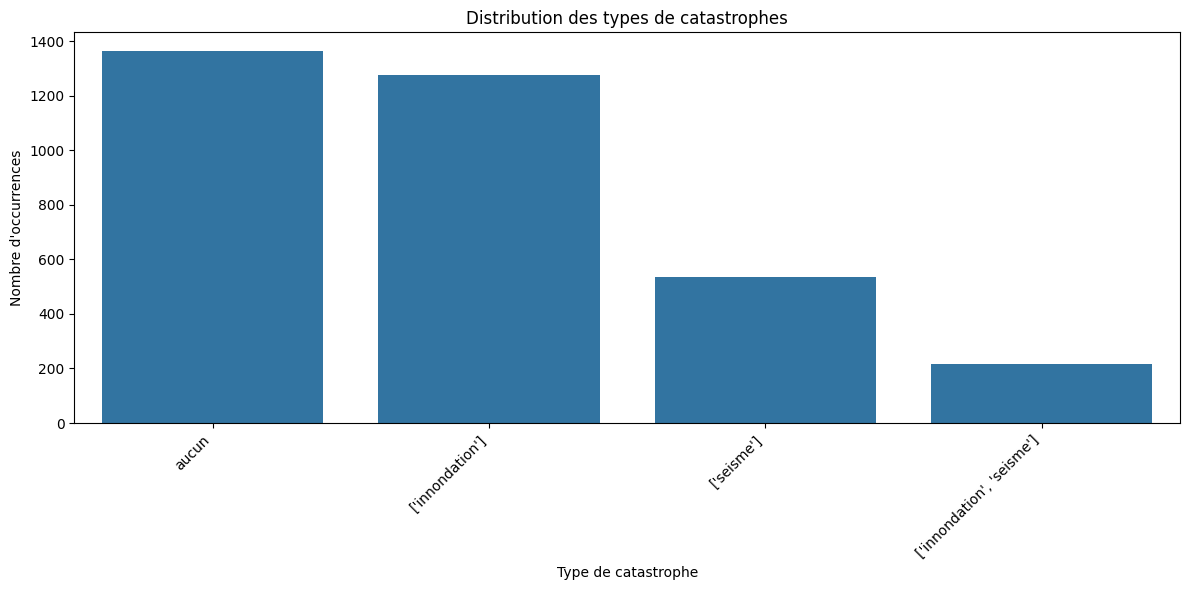

In [106]:
# Compter les occurrences de chaque type de catastrophe
counts = df.group_by('catastrophe').len().sort('len', descending=True)

# Convertir en DataFrame pandas pour faciliter la visualisation
# D'abord convertir en pandas standard
df_pandas = df.to_pandas()

# Créer un dictionnaire pour remapper les indices aux noms des catastrophes
catastrophe_names = {i: name for i, name in enumerate(catastrophes)}

# Compter directement avec pandas
counts_pd = df_pandas['catastrophe'].map(lambda x: catastrophe_names.get(x, str(x))).value_counts().reset_index()
counts_pd.columns = ['nom_catastrophe', 'count']

# Créer le graphique
plt.figure(figsize=(12, 6))
sns.barplot(x='nom_catastrophe', y='count', data=counts_pd)
plt.title('Distribution des types de catastrophes')
plt.xlabel('Type de catastrophe')
plt.ylabel("Nombre d\'occurrences")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

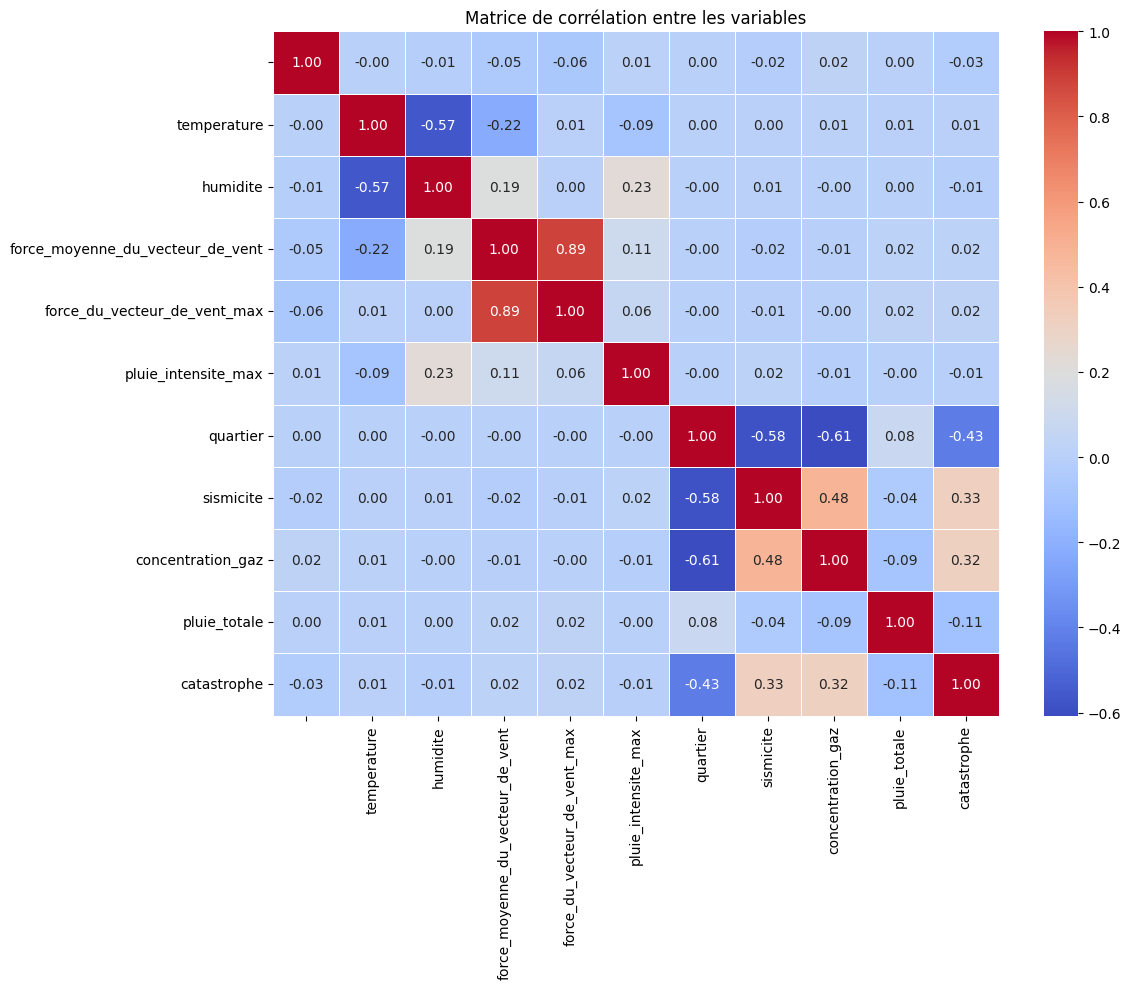

In [107]:
# Convertir en pandas pour utiliser la fonction corr() et heatmap de seaborn
df_pd = df.to_pandas()

# Calculer la matrice de corrélation des variables numériques
numeric_cols = df_pd.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df_pd[numeric_cols].corr()

# Créer une heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation entre les variables')
plt.tight_layout()
plt.show()

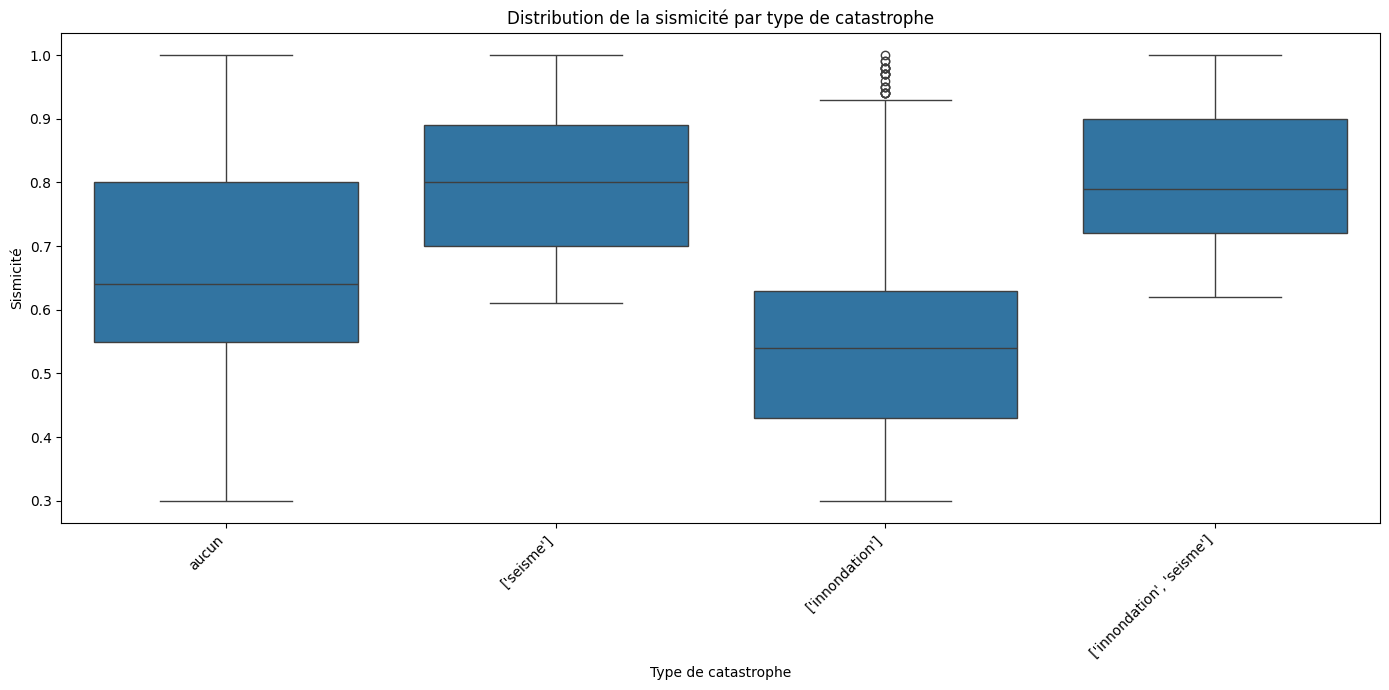

In [108]:
# Boxplot de la sismicité par type de catastrophe
df_pd = df.to_pandas()

# Créer un dictionnaire pour remapper les indices aux noms des catastrophes
catastrophe_names = {i: name for i, name in enumerate(catastrophes)}
df_pd['nom_catastrophe'] = df_pd['catastrophe'].map(lambda x: catastrophe_names.get(x, str(x)))

plt.figure(figsize=(14, 7))
sns.boxplot(x='nom_catastrophe', y='sismicite', data=df_pd)
plt.title('Distribution de la sismicité par type de catastrophe')
plt.xlabel('Type de catastrophe')
plt.ylabel('Sismicité')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/5t/_4b401m524v50md9wzh4gxvh0000gn/T/ipykernel_29419/4010192250.py:2: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  quartier_catastrophe = df.group_by(['quartier', 'catastrophe']).count()


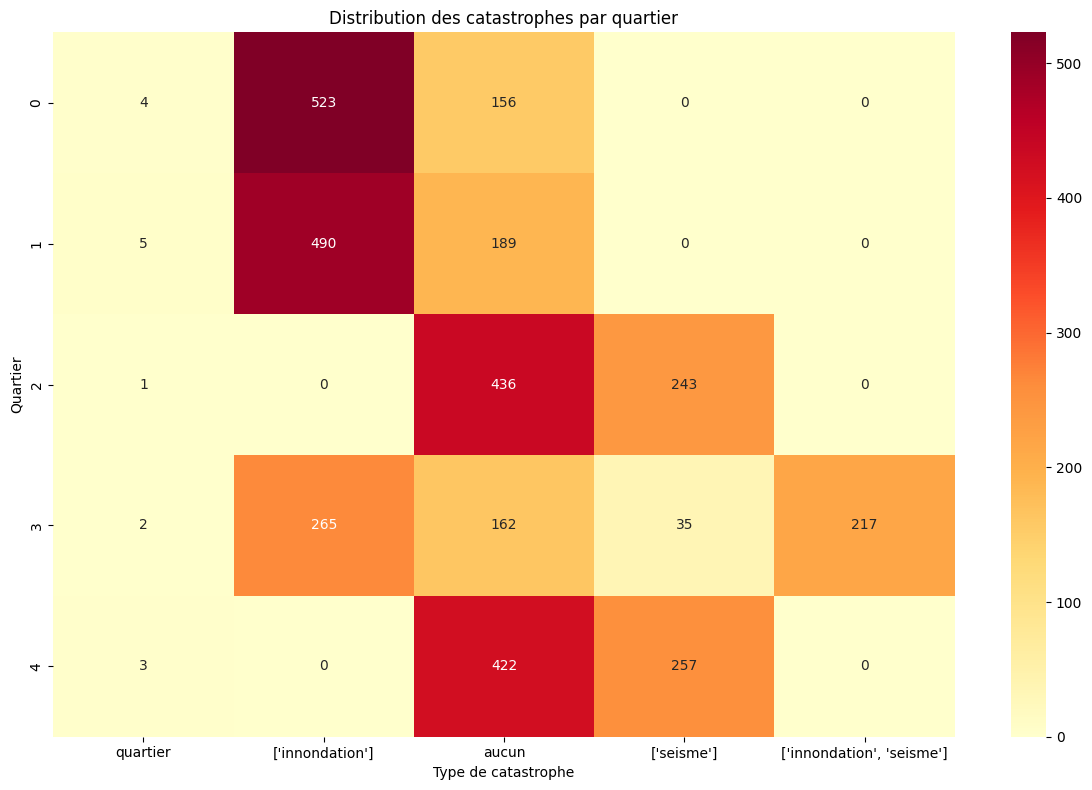

In [115]:
# Analyser la distribution des catastrophes par quartier
quartier_catastrophe = df.group_by(['quartier', 'catastrophe']).count()
quartier_catastrophe = quartier_catastrophe.pivot(index='quartier', on='catastrophe', values='count')

# Remplacer les valeurs None par 0
quartier_catastrophe = quartier_catastrophe.fill_null(0)

# Convertir en pandas pour la visualisation
qc_pd = quartier_catastrophe.to_pandas()

# Renommer les colonnes avec les noms des catastrophes
qc_pd.columns = [catastrophe_names.get(int(col), col) if col != 'quartier' else 'quartier' for col in qc_pd.columns]

# Créer un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(qc_pd, annot=True, cmap='YlOrRd', fmt='g')
plt.title('Distribution des catastrophes par quartier')
plt.ylabel('Quartier')
plt.xlabel('Type de catastrophe')
plt.tight_layout()
plt.show()

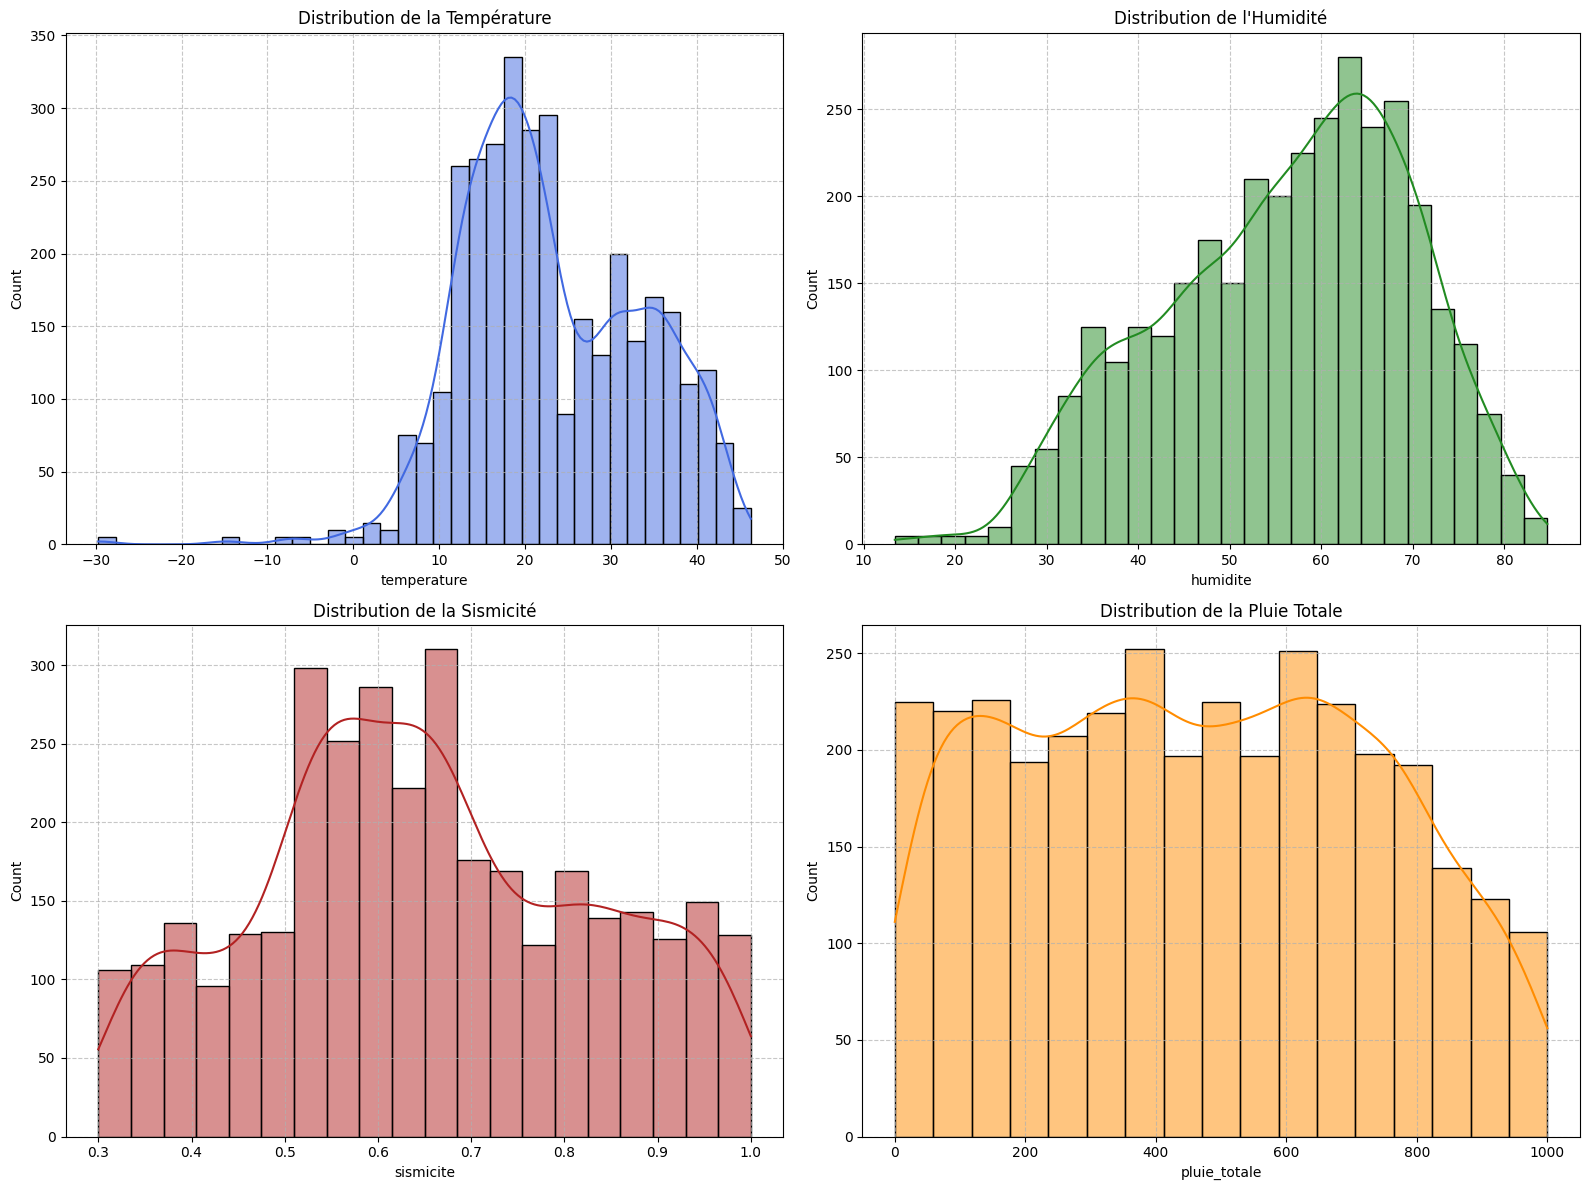

In [110]:
# Distribution des variables numériques clés
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Convertir en pandas pour utiliser seaborn
df_pd = df.to_pandas()

# Température
sns.histplot(df_pd['temperature'], kde=True, ax=axes[0, 0], color='royalblue')
axes[0, 0].set_title('Distribution de la Température')
axes[0, 0].grid(True, linestyle='--', alpha=0.7)

# Humidité
sns.histplot(df_pd['humidite'], kde=True, ax=axes[0, 1], color='forestgreen')
axes[0, 1].set_title('Distribution de l\'Humidité')
axes[0, 1].grid(True, linestyle='--', alpha=0.7)

# Sismicité
sns.histplot(df_pd['sismicite'], kde=True, ax=axes[1, 0], color='firebrick')
axes[1, 0].set_title('Distribution de la Sismicité')
axes[1, 0].grid(True, linestyle='--', alpha=0.7)

# Pluie totale
sns.histplot(df_pd['pluie_totale'], kde=True, ax=axes[1, 1], color='darkorange')
axes[1, 1].set_title('Distribution de la Pluie Totale')
axes[1, 1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

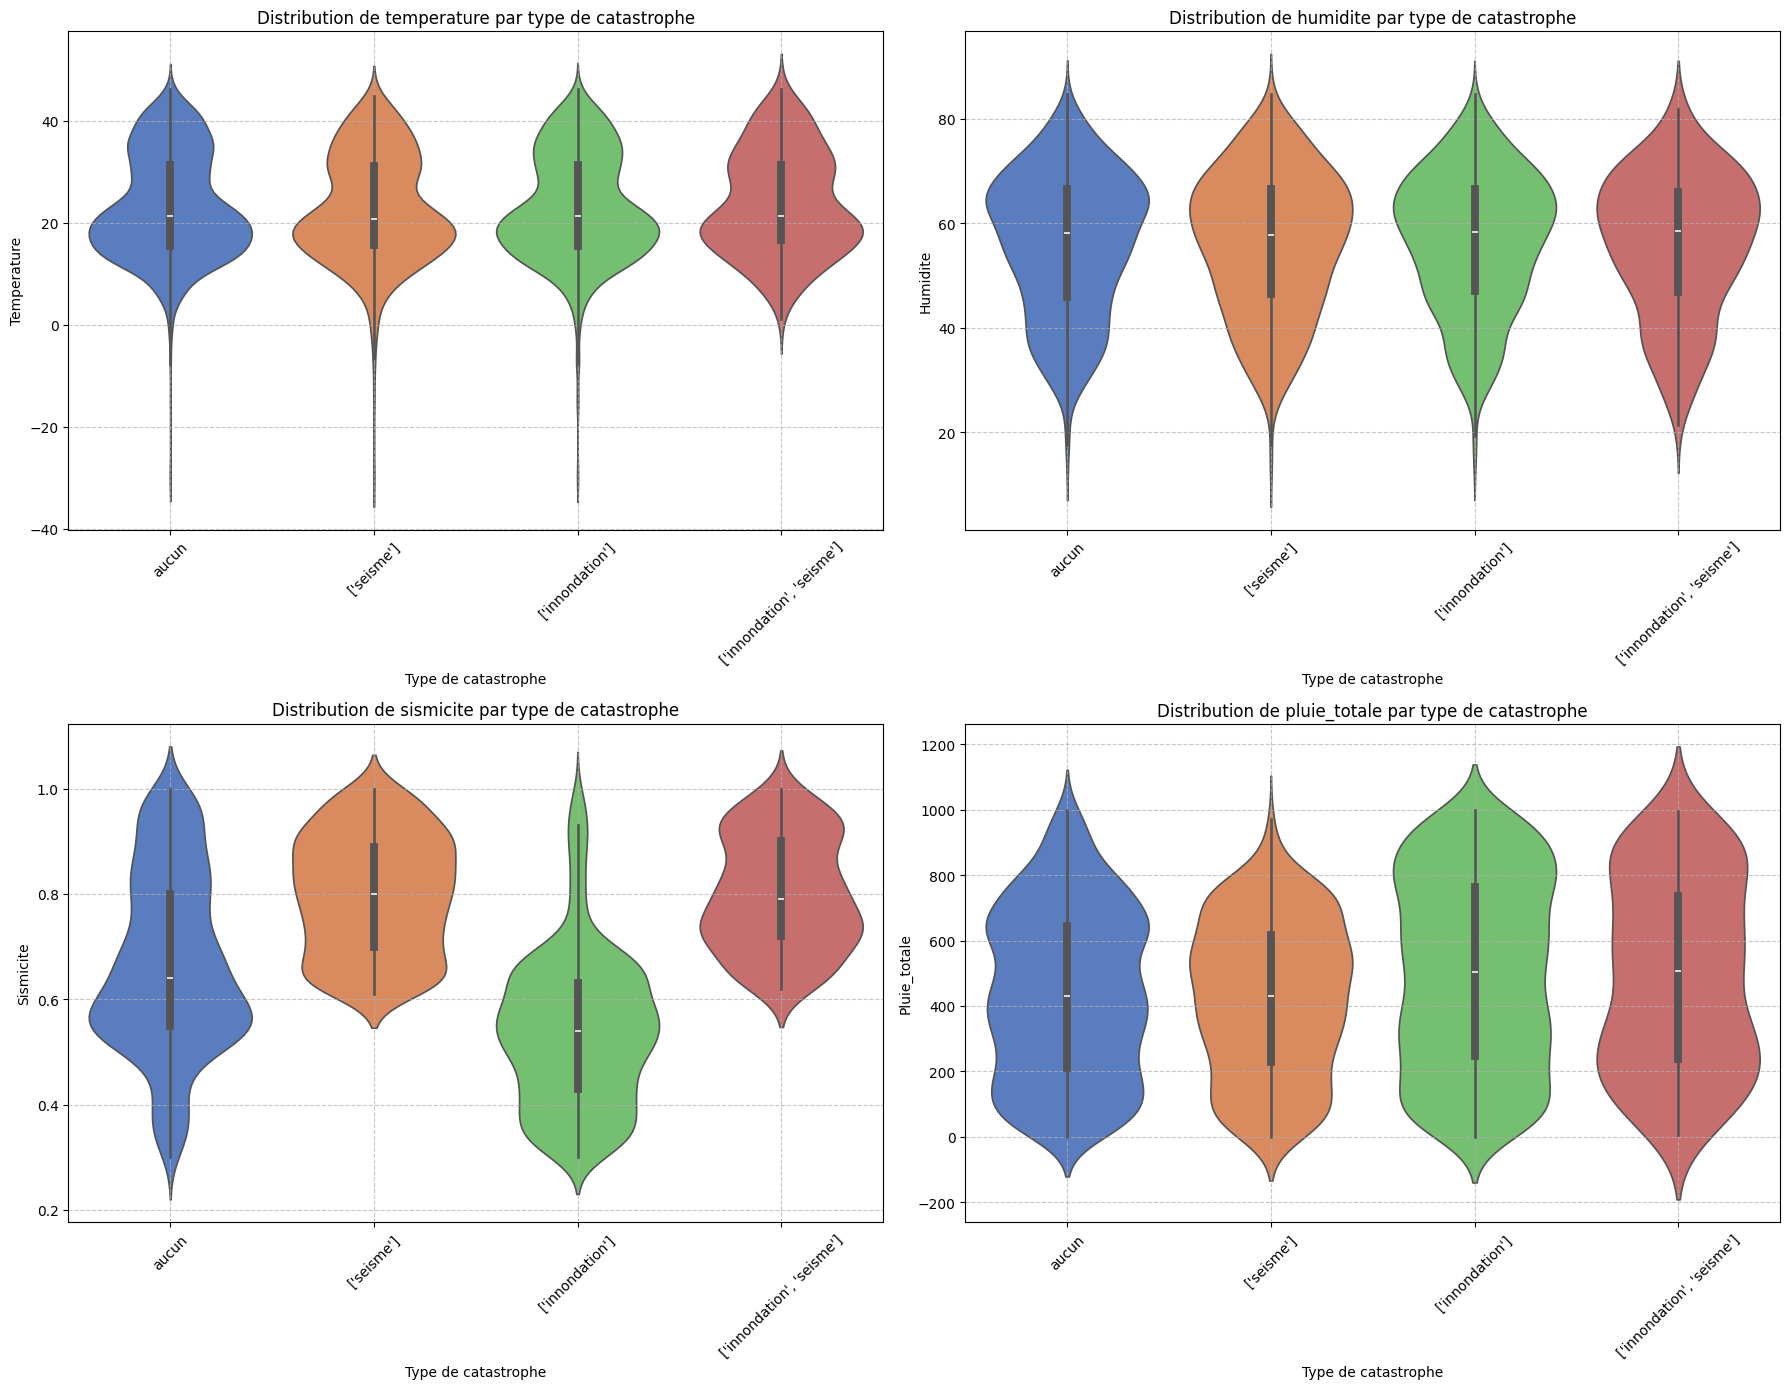

In [111]:
# Graphiques en violon pour visualiser la distribution des variables par type de catastrophe
df_pd = df.to_pandas()

# Ajouter les noms des catastrophes
catastrophe_names = {i: name for i, name in enumerate(catastrophes)}
df_pd['nom_catastrophe'] = df_pd['catastrophe'].map(lambda x: catastrophe_names.get(x, str(x)))

# Variables à analyser
variables = ['temperature', 'humidite', 'sismicite', 'pluie_totale']

# Créer le subplot
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

# Pour chaque variable, créer un graphique en violon
for i, var in enumerate(variables):
    sns.violinplot(x='nom_catastrophe', y=var, data=df_pd, ax=axes[i], hue='nom_catastrophe', palette='muted', legend=False)
    axes[i].set_title(f'Distribution de {var} par type de catastrophe')
    axes[i].set_xlabel('Type de catastrophe')
    axes[i].set_ylabel(var.capitalize())
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

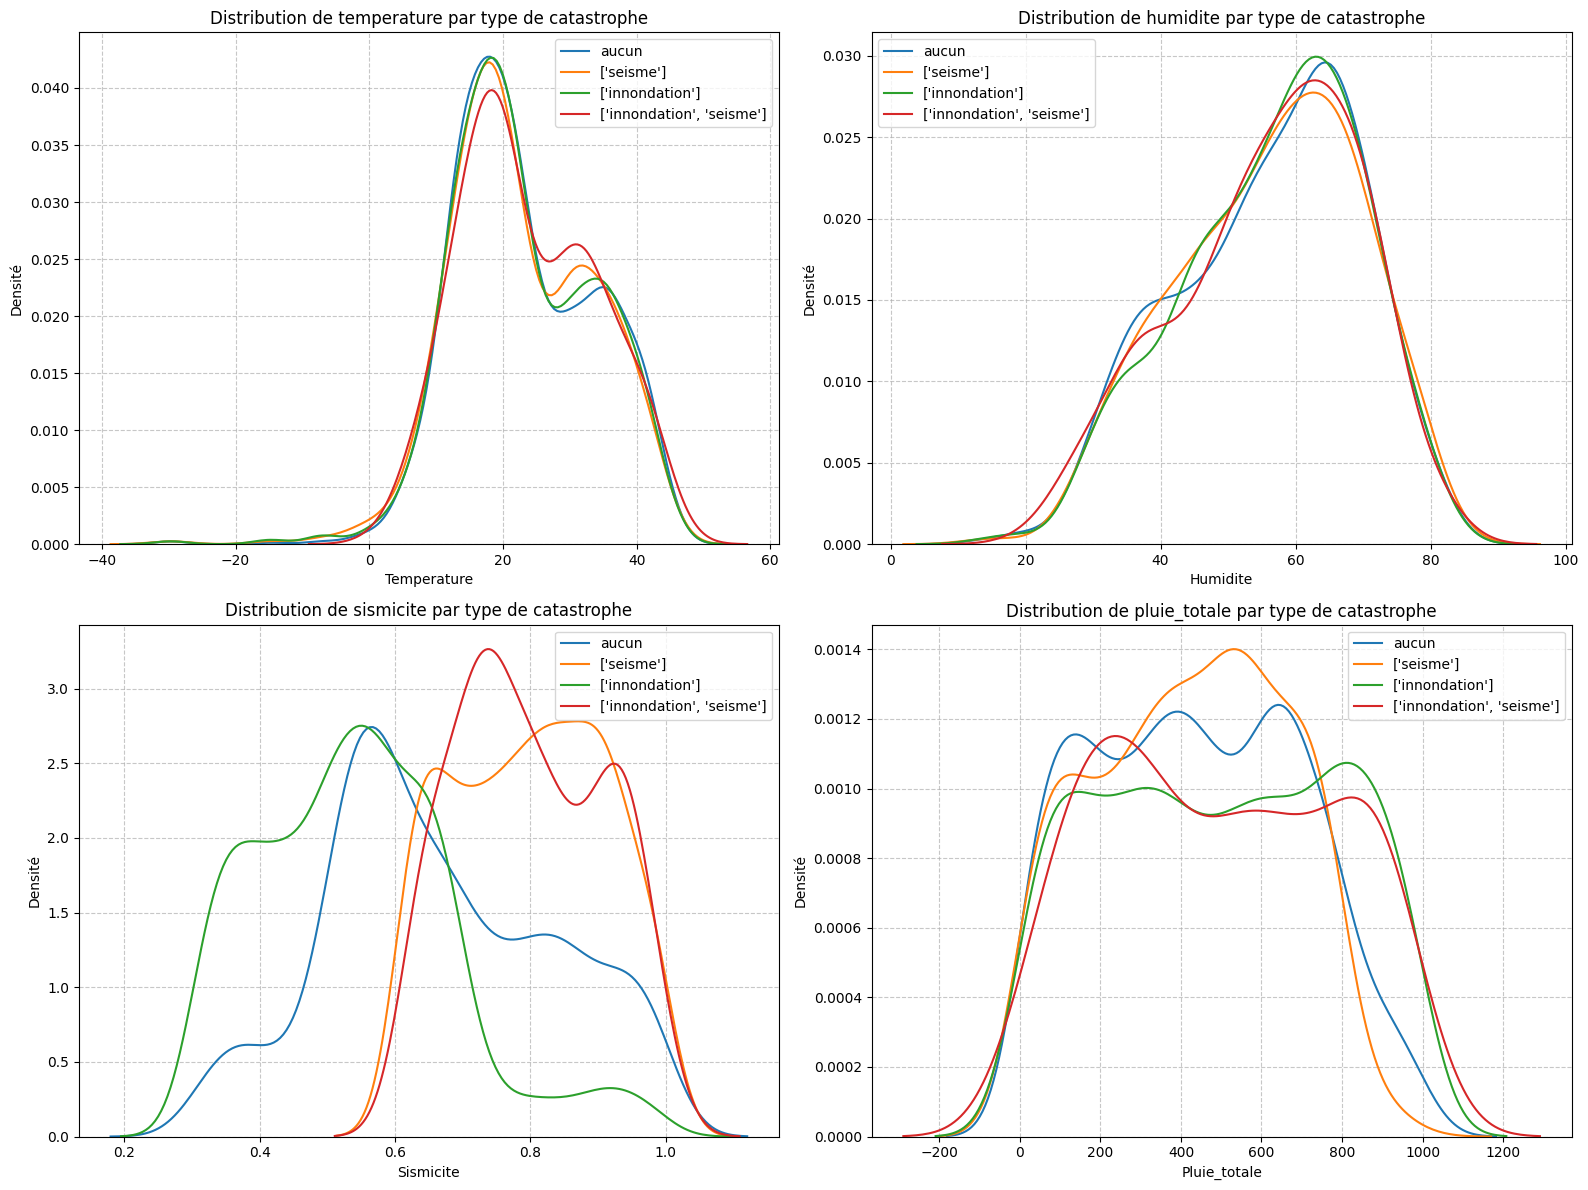

In [112]:
# Graphiques KDE (Kernel Density Estimation) pour les variables clés
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Filtrer les données pour chaque type de catastrophe
df_pd = df.to_pandas()
df_pd['nom_catastrophe'] = df_pd['catastrophe'].map(lambda x: catastrophe_names.get(x, str(x)))

# Liste des variables à analyser
variables = ['temperature', 'humidite', 'sismicite', 'pluie_totale']

# Pour chaque variable, créer un graphique KDE par type de catastrophe
for i, var in enumerate(variables):
    ax = axes[i//2, i%2]
    for cat in df_pd['nom_catastrophe'].unique():
        sns.kdeplot(df_pd[df_pd['nom_catastrophe'] == cat][var], ax=ax, label=cat)
    ax.set_title(f'Distribution de {var} par type de catastrophe')
    ax.set_xlabel(var.capitalize())
    ax.set_ylabel('Densité')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Vérification de la continuité des dates

In [118]:
# Extraction des dates uniques
dates_uniques = df.select('date').unique().sort('date')

# Convertir en liste pour analyse
dates_liste = dates_uniques['date'].to_list()

# Afficher le nombre total de dates uniques
print(f"Nombre total de dates uniques: {len(dates_liste)}")

# Vérifier les écarts entre les dates consécutives
diff_dates = []
dates_manquantes = []

for i in range(1, len(dates_liste)):
    diff = dates_liste[i] - dates_liste[i-1]
    diff_jours = diff.total_seconds() / (60*60*24)  # Conversion en jours
    
    if diff_jours > 1:  # Si l'écart est supérieur à 1 jour
        dates_manquantes.append((dates_liste[i-1], dates_liste[i], diff_jours))
    
    diff_dates.append(diff_jours)

# Afficher les statistiques sur les écarts entre dates
if diff_dates:
    print(f"\nStatistiques sur les écarts entre dates consécutives (en jours):")
    print(f"Minimum: {min(diff_dates)}")
    print(f"Maximum: {max(diff_dates)}")
    print(f"Moyenne: {sum(diff_dates)/len(diff_dates):.2f}")
    
    # Afficher les intervalles manquants s'il y en a
    if dates_manquantes:
        print(f"\nIntervalles avec coupures détectés:")
        for debut, fin, jours in dates_manquantes:
            print(f"Coupure entre {debut} et {fin} ({jours:.0f} jours)")
    else:
        print("\nAucune coupure détectée dans les dates. La série temporelle est continue.")
else:
    print("Pas assez de dates pour analyser la continuité.")

Nombre total de dates uniques: 679

Statistiques sur les écarts entre dates consécutives (en jours):
Minimum: 1.0
Maximum: 39.0
Moyenne: 1.08

Intervalles avec coupures détectés:
Coupure entre 2170-02-01 et 2170-02-03 (2 jours)
Coupure entre 2170-02-10 et 2170-02-12 (2 jours)
Coupure entre 2170-04-21 et 2170-04-23 (2 jours)
Coupure entre 2170-08-09 et 2170-09-17 (39 jours)
Coupure entre 2170-09-29 et 2170-10-01 (2 jours)
Coupure entre 2170-11-19 et 2170-11-21 (2 jours)
Coupure entre 2171-01-15 et 2171-01-17 (2 jours)
Coupure entre 2171-01-27 et 2171-01-29 (2 jours)
Coupure entre 2171-05-03 et 2171-05-05 (2 jours)
Coupure entre 2171-08-04 et 2171-08-06 (2 jours)
Coupure entre 2171-09-20 et 2171-09-22 (2 jours)
Coupure entre 2171-10-18 et 2171-10-20 (2 jours)
Coupure entre 2171-11-01 et 2171-11-03 (2 jours)
Coupure entre 2171-11-17 et 2171-11-19 (2 jours)


/var/folders/5t/_4b401m524v50md9wzh4gxvh0000gn/T/ipykernel_29419/3577718135.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('nombre_observations')


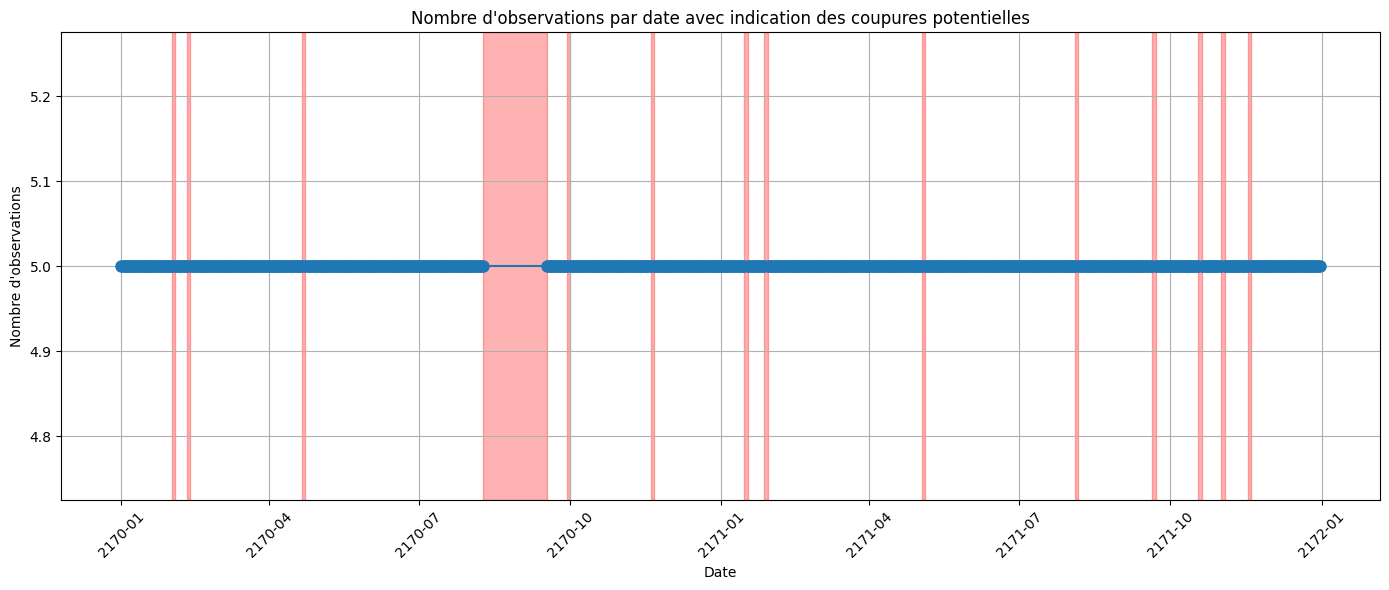

In [119]:
# Visualisation de la continuité temporelle

# Créer un DataFrame avec toutes les dates et le nombre d'observations
date_count = df.group_by('date').agg(
    pl.count().alias('nombre_observations')
).sort('date')

# Convertir en pandas pour la visualisation
date_count_pd = date_count.to_pandas()
date_count_pd.set_index('date', inplace=True)

# Créer le graphique
plt.figure(figsize=(14, 6))

# Tracer le nombre d'observations par date
plt.plot(date_count_pd.index, date_count_pd['nombre_observations'], 'o-', markersize=8)

# Ajouter des lignes verticales pour les dates manquantes
if dates_manquantes:
    for debut, fin, _ in dates_manquantes:
        plt.axvspan(debut, fin, color='red', alpha=0.3)

plt.title('Nombre d\'observations par date avec indication des coupures potentielles')
plt.xlabel('Date')
plt.ylabel('Nombre d\'observations')
plt.grid(True)

# Rotation des dates sur l'axe x pour une meilleure lisibilité
plt.xticks(rotation=45)

# Ajuster automatiquement l'espacement
plt.tight_layout()

plt.show()